In [1]:
# Step 1: Standardize Numerical Data
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_csv("cleaned_data.csv") 
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
df_num = df[numerical_features].dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_num)

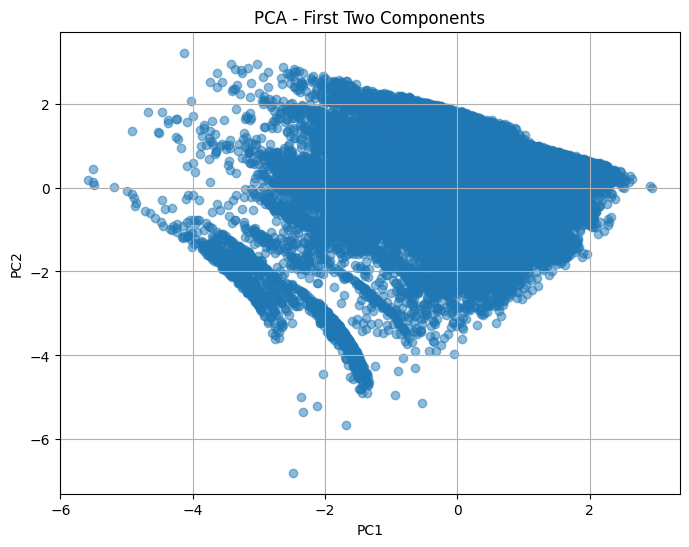

In [2]:
# Step 2: Apply PCA for Dimensionality Reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Plot PCA results
plt.figure(figsize=(8,6))
plt.scatter(pca_components[:,0], pca_components[:,1], alpha=0.5)
plt.title('PCA - First Two Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

The PCA plot above represents the first two principal components derived from the full set of scaled and encoded customer features. The shape suggests that customer profiles vary meaningfully along these combined feature axes.


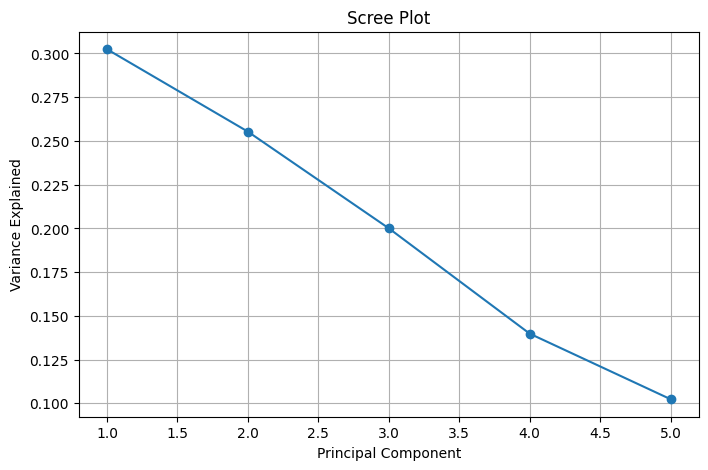

In [3]:
pca_full = PCA()
pca_full.fit(scaled_data)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_)+1), pca_full.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()


## Scree Plot Interpretation

The scree plot shows how much variance each principal component explains. The first few components (especially PC1 through PC3) capture the majority of the variance in the dataset:

- **PC1** explains approximately 30% of the variance.
- **PC2** explains approximately 25%.
- **PC3** adds another 20%.

This suggests that using the first 3–4 principal components would retain most of the important information in the data while reducing dimensionality. This also aligns with the "elbow" point in the scree plot, where the additional benefit of including more components begins to diminish.


In [4]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_data)
explained = pca.explained_variance_ratio_
print(f"Explained variance by PC1, PC2, and PC3: {explained}")
print(f"Total variance captured by first 3 components: {explained.sum():.4f}")

Explained variance by PC1, PC2, and PC3: [0.30240942 0.25531385 0.20006184]
Total variance captured by first 3 components: 0.7578


## Variance by PCA Components

The first three principal components explain the majority of the variance in the dataset:

- **PC1**: 30.2%
- **PC2**: 25.5%
- **PC3**: 20.0%

Together, these components capture approximately **75.8%** of the total variance.

This justifies using the first three components for clustering, as they preserve most of the information in a reduced dimensional space while filtering out noise and redundancy. 

In [5]:
pca_components_df = pd.DataFrame(pca.components_, columns=df_num.columns, index=['PC1', 'PC2', 'PC3'])

print("Top contributors to PC1:")
display(pca_components_df.loc['PC1'].sort_values(ascending=False))

print("Top contributors to PC2:")
display(pca_components_df.loc['PC2'].sort_values(ascending=False))

print("Top contributors to PC3:")
display(pca_components_df.loc['PC3'].sort_values(ascending=False))


Top contributors to PC1:


Profit Margin    0.643600
Year             0.574931
Quantity         0.272930
Customer Age     0.043289
Unit Price      -0.422928
Name: PC1, dtype: float64

Top contributors to PC2:


Quantity         0.653789
Customer Age    -0.114349
Profit Margin   -0.274820
Year            -0.408395
Unit Price      -0.563180
Name: PC2, dtype: float64

Top contributors to PC3:


Customer Age     0.984671
Quantity         0.133472
Unit Price       0.012130
Year            -0.003681
Profit Margin   -0.111571
Name: PC3, dtype: float64

The principal component loadings show how original features contribute to each component:

- PC1 (30.2% of variance) emphasizes Profit Margin, Year, and Quantity, with a negative association with Unit Price. This component differentiates profitable and recent customers from those purchasing higher-priced items.
  
- PC2 (25.5%) is driven by Quantity positively and contrasts that with Unit Price, Year, and Profit Margin negatively. It appears to separate frequent, low-cost purchasers from occasional, high-cost buyers.

- PC3 (20.0%) is dominated by Customer Age, highlighting an age-based separation in the data that may reflect generational purchasing patterns.


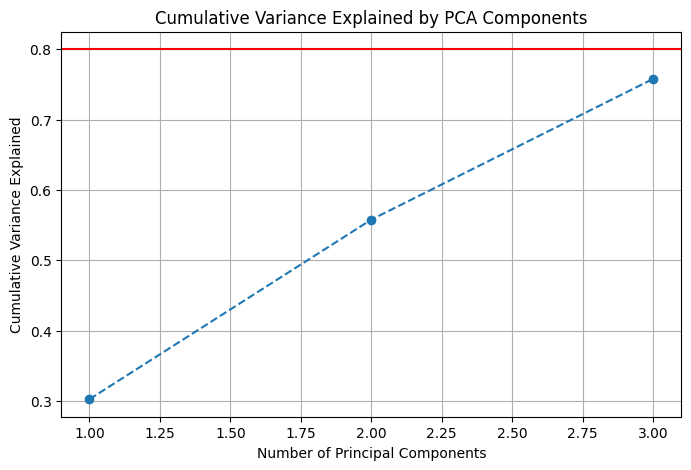

In [6]:
import numpy as np
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='-')  # 80% variance threshold
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()


In [ ]:
# Step 3: KMeans - Elbow Method and Silhouette Scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sse = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_data, kmeans.labels_))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

Optimal Number of Clusters:
- The Elbow Method suggests an inflection point around k = 3 or 4, where adding more clusters leads to smaller gains in reducing within-cluster variance.
- The Silhouette Score peaks at k = 4, indicating this is the most cohesive and well-separated clustering structure among the values tested.

Based on this combined evidence, we will be selecting k = 4 as the optimal number of clusters for segmenting the customer data.


In [83]:
import plotly.express as px
import pandas as pd

df_clustered = df.copy()
df_clustered['Cluster'] = clusters

# Join PCA features
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([pca_df, df_clustered[['Cluster', 'Customer Age', 'Quantity', 'Profit Margin']].reset_index(drop=True)], axis=1)

fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    color=pca_df['Cluster'].astype(str),
    title='Interactive 3D PCA Clustering with Customer Info',
    opacity=0.7,
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={
        'Cluster': True,
        'Customer Age': True,
        'Quantity': True,
        'Profit Margin': True,
        'PC1': False, 'PC2': False, 'PC3': False  # Optional: hide PCA coords
    }
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()


The 3D scatterplot above visualizes customer segments based on the top three PCA components. Each point represents a customer, and colors reflect the KMeans cluster assignments (k = 4).

In [84]:
fig.write_html("interactive_customer_clusters.html")

In [85]:
# Attach clusters to original df
df_clustered = df_num.copy()
df_clustered['Cluster'] = clusters

# Summarize stats per cluster
cluster_summary = df_clustered.groupby('Cluster').mean()
display(cluster_summary)


,Year,Customer Age,Quantity,Unit Price,Profit Margin
Cluster,,,,,
0,2015.011281,35.615556,2.118376,269.364665,0.061112
1,2015.942304,36.536038,1.000171,348.913970,0.204410
2,2015.531272,37.510771,1.225156,1775.069840,0.063254
3,2015.999132,36.872011,2.517873,220.539954,0.195320


## Cluster Profiles

Based on the clustering results and key customer features, we identified the following segments:

### 🟦 Cluster 0: **Moderate Spenders**
- **Avg Age**: 35.6
- **Quantity Purchased**: ~2.1
- **Unit Price**: $269
- **Profit Margin**: Low (0.06)
Tend to make medium-volume purchases of moderately priced items, but bring lower profit margins.

---

### 🟩 Cluster 1: **Low-Volume High-Margin Buyers**
- **Avg Age**: 36.5
- **Quantity Purchased**: ~1.0
- **Unit Price**: $349
- **Profit Margin**: Highest (0.20)
Possibly newer customers who purchase infrequently but generate significant profit per unit.

---

### 🟪 Cluster 2: **Premium Shoppers**
- **Avg Age**: 37.5 (oldest)
- **Quantity Purchased**: ~1.2
- **Unit Price**: Very high ($1775)
- **Profit Margin**: Low (0.06)
Purchase expensive products but with low profit margins. May be bulk buyers of discounted luxury.

---

### 🟧 Cluster 3: **Frequent Value Seekers**
- **Avg Age**: 36.9
- **Quantity Purchased**: Highest (~2.5)
- **Unit Price**: Lowest ($220)
- **Profit Margin**: High (0.19)
High-volume shoppers buying low-cost but high-margin items. Great for recurring revenue.

---

## Recommendation:
- **Cluster 3** may be ideal for loyalty programs and upselling.
- **Cluster 1** shows potential for high-margin product marketing.
- **Cluster 2** may need profitability review (are costs too high?).
- **Cluster 0** could be nurtured toward higher-margin items.



In [86]:
df_raw = pd.read_csv("Data.csv")
df_clustered['Country'] = df_raw['Country']



In [87]:
# Group by Country and Cluster
country_cluster_summary = df_clustered.groupby(['Country', 'Cluster']).agg({
    'Quantity': 'mean',
    'Unit Price': 'mean',
    'Profit Margin': 'mean',
    'Customer Age': 'mean'
}).reset_index()

display(country_cluster_summary)


,Country,Cluster,Quantity,Unit Price,Profit Margin,Customer Age
0,France,0,2.179551,270.138238,-0.007202,34.581047
1,France,1,1.000000,346.695556,0.180273,35.401111
2,France,2,1.246377,1740.819876,0.016231,36.790890
3,France,3,2.528652,223.364232,0.182260,35.434270
4,Germany,0,2.267209,283.542762,0.209981,34.152691
5,Germany,1,1.000956,404.523423,0.309405,35.413002
6,Germany,2,1.298658,1974.351510,0.189329,36.164430
7,Germany,3,2.520143,279.261516,0.312321,34.756757
8,United Kingdom,0,2.085539,281.411201,0.062604,35.205600
9,United Kingdom,1,1.000000,342.863727,0.196646,35.828657


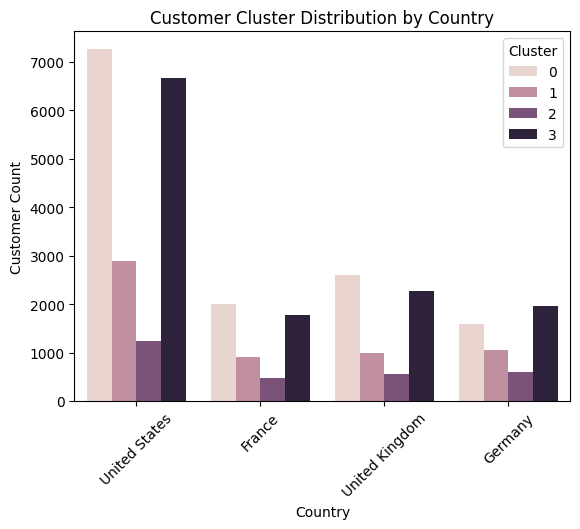

In [88]:
import seaborn as sns

sns.countplot(data=df_clustered, x='Country', hue='Cluster')
plt.title("Customer Cluster Distribution by Country")
plt.ylabel("Customer Count")
plt.xticks(rotation=45)
plt.show()


This bar chart visualizes how customer clusters are distributed across key countries.

- **Cluster 0** (Moderate Spenders) and **Cluster 3** (Frequent Value Seekers) dominate the U.S. market, accounting for the vast majority of customers.
- **France** and **Germany** show a more diverse distribution of clusters, indicating varied customer behaviors and product engagement.
- **Cluster 1** (Low-volume high-margin buyers) has a smaller footprint across all countries, possibly reflecting a niche group.

This suggests that:
- U.S. strategies may benefit from volume-driven promotions and loyalty incentives.
- European countries could support more differentiated marketing based on segment-specific needs.

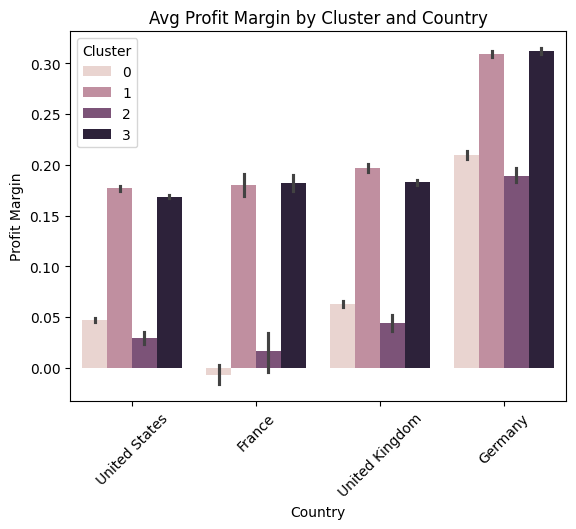

In [89]:
sns.barplot(data=df_clustered, x='Country', y='Profit Margin', hue='Cluster')
plt.title("Avg Profit Margin by Cluster and Country")
plt.xticks(rotation=45)
plt.show()

## Average Profit Margin by Cluster and Country

- **Germany** is the most profitable across all clusters, especially Cluster 1 (low-volume, high-margin buyers) and Cluster 3 (frequent value seekers).
- **France’s Cluster 0** shows a negative margin — this may indicate an unprofitable product group or discounting strategy.
- **The U.S.** performs moderately well, with Cluster 3 providing consistent margins, but Cluster 2 delivering minimal return.
- **The UK** shows steady margins across Clusters 1 and 3, suggesting a balanced and healthy segment mix.

We can use Germany as a benchmark for what strong customer performance looks like.


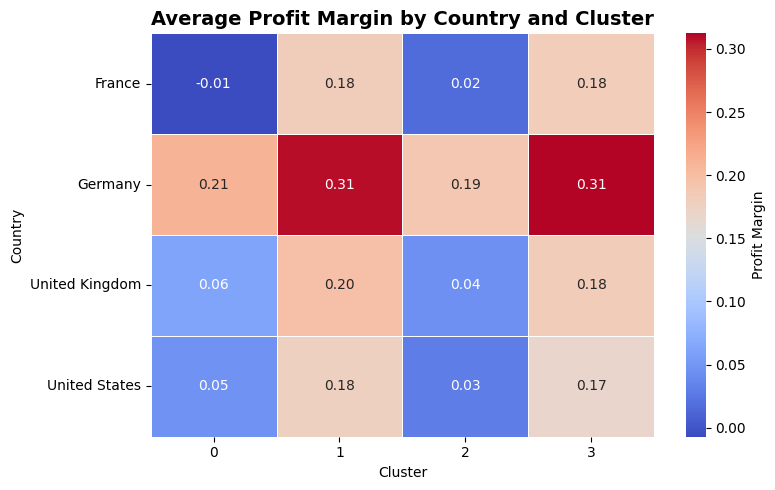

In [90]:
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, cmap='coolwarm', annot=True, linewidths=0.5, fmt=".2f", cbar_kws={'label': 'Profit Margin'})
plt.title("Average Profit Margin by Country and Cluster", fontsize=14, weight='bold')
plt.xlabel("Cluster")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig("heatmap_profit_margin_by_country_cluster.png", dpi=300)



## Heatmap: Average Profit Margin by Country and Cluster

This heatmap visualizes the average profit margin for each customer segment (cluster) across the top four countries in the dataset. Each value represents the mean profit margin for customers in a specific cluster-country combination.

### Key Insights:
- **Germany** stands out as the most consistently profitable market, with Clusters 1 and 3 yielding the highest margins (0.31).
- **France** shows a notable concern in **Cluster 0**, with an average **negative margin (-0.01)** — this suggests a potential pricing or cost issue!
- Both the **United Kingdom** and the **United States** see highest performance in **Cluster 1**, while **Cluster 2** underperforms in both regions.
- **Cluster 3** remains a stable, high-performing segment across all countries, making it a valuable focus for retention or loyalty strategies.

### Takeaway:
- **Cluster 1 and 3 patterns in Germany** as a benchmark for expanding high-margin strategies globally.
- Investigate operational, pricing, or product issues in **France’s Cluster 0** and **Cluster 2** across all countries.
